# Evaluation - `misc_dia`

This notebook loads a trained Encoder-Only Transformer model and evaluates it on validation/test data, and shows how to predict RT for new peptide sequences on `misc_dia` dataset.

---

## 1. Setup & Imports

In [1]:
import sys
sys.path.append('../src')

from rt_transformer import AATokenizer, PeptideRTDataset, PeptideRTDecoderModel, split_dataset, collate, compute_metrics

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

import numpy as np
import random

## 2. Configuration
Set data and saved model paths and model hyperparameters (must match training!).

In [2]:
DATA_PATH = "../data/misc_dia.txt"
MODEL_PATH = "../models/misc_dia_decoder.pt"
VAL_RATIO = 0.05 # 1 for entire dataset evaluation

D_MODEL = 192
N_HEADS = 4
N_LAYERS = 3
N_QUERIES = 20
DISABLE_SELF_ATTN = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using device: cuda


## 3. Load Data and Model

In [3]:
# Tokenizer and dataset
tokenizer = AATokenizer()
dataset = PeptideRTDataset(DATA_PATH, tokenizer)
print(f"Dataset size: {len(dataset)} samples")

# Use the same split as in training
_, val_ds = split_dataset(dataset, val_ratio=VAL_RATIO, seed=42)
coll = lambda b: collate(b, tokenizer.pad_id)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, collate_fn=coll)

# Model
model = PeptideRTDecoderModel(
    tokenizer,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=4*D_MODEL,
    n_layers=N_LAYERS,
    n_queries=N_QUERIES,
    disable_self_attn=DISABLE_SELF_ATTN
)

#if torch.cuda.is_available():
#    model = nn.DataParallel(model)

model=model.to(DEVICE)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
print(f"Model size: {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters")

Dataset size: 146587 samples
Model size: 1826882 parameters


## 4. Evaluate on Validation Set

In [4]:
# Get predictions and targets
all_preds, all_targets, all_peptides = [], [], []

with torch.no_grad():
    model.eval()
    for batch in val_loader:
        seqs, mask, rts = batch
        seqs, mask = seqs.to(DEVICE), mask.to(DEVICE)
        preds = model(seqs, mask).cpu().numpy()

        all_preds.append(preds)
        all_targets.append(rts.numpy())

        # Decode each sequence in the batch
        # seqs is a tensor of shape (batch_size, seq_len)
        decoded_batch = [dataset.tok.decode(seq.cpu().tolist()) for seq in seqs]
        all_peptides.extend(decoded_batch)

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

Compute main metrics.

In [5]:
# Convert numpy arrays to torch tensors
all_preds_torch = torch.tensor(all_preds)
all_targets_torch = torch.tensor(all_targets)

metrics = compute_metrics(all_preds_torch, all_targets_torch)
print("\nValidation metrics for model:")
for k, v in metrics.items():
    print(f"{k:26s}: {v:.5f}")


Validation metrics for model:
MAE                       : 0.02165
MSE                       : 0.00091
RMSE                      : 0.03016
Max_Abs_Error             : 0.17483
Median_Abs_Error          : 0.01557
Mean_Abs_Percentage_Error : 0.05314
Std_Error                 : 0.02978
Std_True                  : 0.18900
Std_Pred                  : 0.18486
R2                        : 0.97453
Explained_Variance        : 0.97517
Pearson                   : 0.98755
Spearman                  : 0.99038


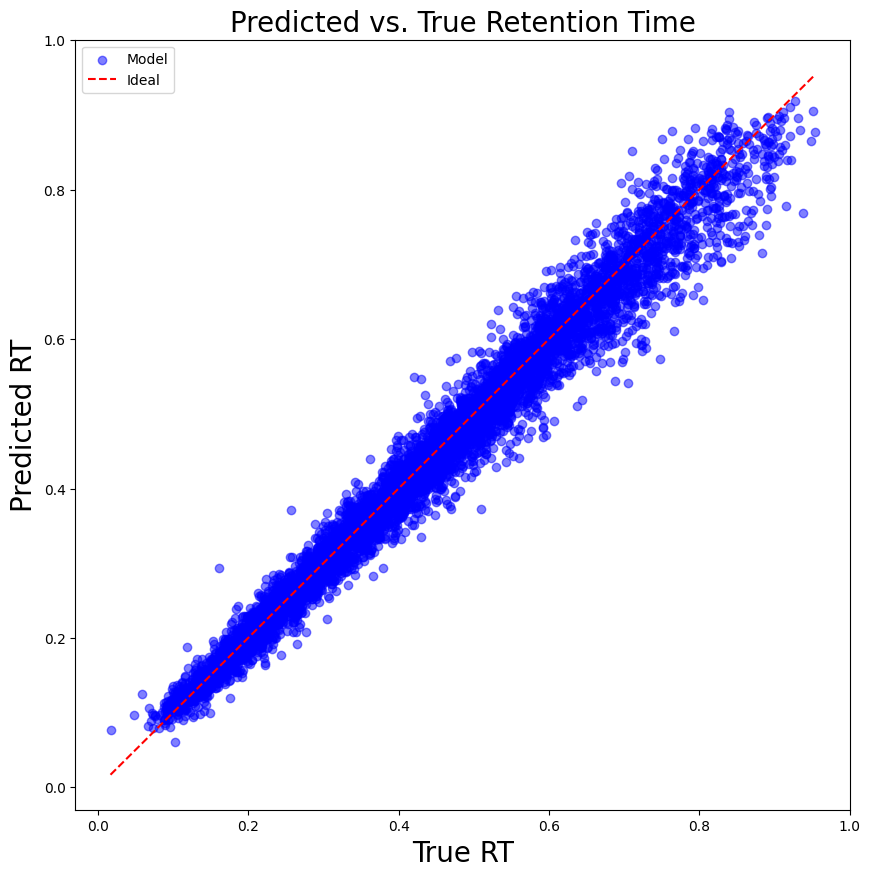

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(all_targets, all_preds, alpha=0.5, label="Model", color="blue")
plt.xlabel("True RT", fontsize=20)
plt.ylabel("Predicted RT", fontsize=20)
plt.title("Predicted vs. True Retention Time", fontsize=20)
plt.plot([all_targets.min(), all_targets.max()],
         [all_targets.min(), all_targets.max()], 'r--', label="Ideal")
plt.legend()
plt.show()

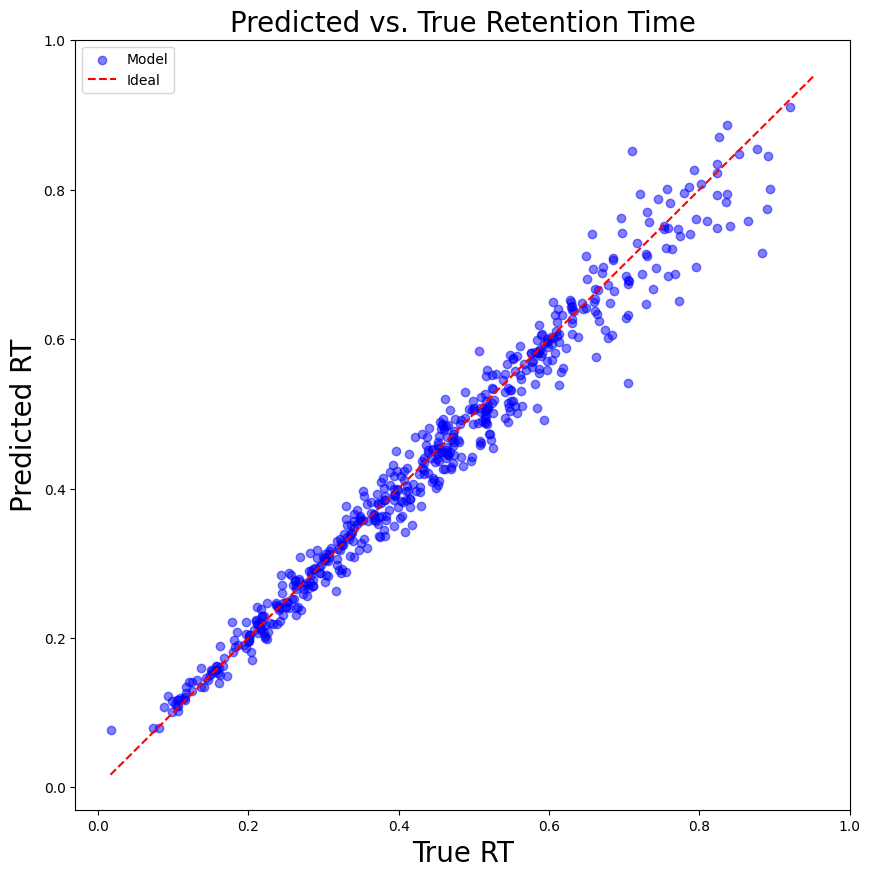

In [7]:
plt.figure(figsize=(10, 10))
plt.scatter(all_targets[:552], all_preds[:552], alpha=0.5, label="Model", color="blue")
plt.xlabel("True RT", fontsize=20)
plt.ylabel("Predicted RT", fontsize=20)
plt.title("Predicted vs. True Retention Time", fontsize=20)
plt.plot([all_targets.min(), all_targets.max()],
         [all_targets.min(), all_targets.max()], 'r--', label="Ideal")
plt.legend()
plt.show()

## 5. Predict RT for New Peptide Sequences
Trained model usage is shown below.

In [8]:
def predict_peptide_rt(peptide_seq, model, tokenizer, device):
    """
    Predict RT for a single peptide sequence (no padding, mask omitted).
    """
    model.eval()
    seq_tensor = tokenizer.encode(peptide_seq).unsqueeze(0).to(device)
    mask = torch.zeros_like(seq_tensor, dtype=torch.bool)  # all False
    with torch.no_grad():
        pred = model(seq_tensor, mask)
    return float(pred.item())

def predict_peptide_batch_rt(peptide_seqs, model, tokenizer, device):
    """
    Predict RTs for a batch of peptide sequences.
    Returns a list of floats.
    """
    model.eval()
    # Encode all sequences (list of tensors of different lengths)
    seqs = [tokenizer.encode(seq) for seq in peptide_seqs]
    # Pad to same length: (batch, max_len)
    seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=tokenizer.pad_id)
    # Mask: True where <pad>
    key_padding_mask = seqs_padded.eq(tokenizer.pad_id)
    seqs_padded, key_padding_mask = seqs_padded.to(device), key_padding_mask.to(device)
    with torch.no_grad():
        preds = model(seqs_padded, key_padding_mask)  # (batch,)
    return preds.cpu().tolist()

# Read all peptides and real RTs from the file
data = []
with open(DATA_PATH, 'r') as f:
    for line in f:
        line = line.strip()
        if line:  # Skip empty lines
            peptide, rt = line.split('\t')
            data.append((peptide, float(rt)))

comparison_data = data[1000:1022]
peptides = [item[0] for item in comparison_data]
real_rts = [item[1] for item in comparison_data]

# ---- Single prediction ----
single_preds = []
for pep in peptides:
    rt_pred = predict_peptide_rt(pep, model, tokenizer, DEVICE)
    single_preds.append(dataset.unnormalize(rt_pred))

# ---- Batch prediction ----
batch_preds = predict_peptide_batch_rt(peptides, model, tokenizer, DEVICE)

# ---- Print comparison table ----
print("\nComparison of Real and Predicted Retention Times:")
print("-" * 85)
print(f"{'Peptide':40}  {'Real RT':>10}  {'Single Pred':>12}  {'Batch Pred':>12}")
print("-" * 85)
for pep, real, single, batch in zip(peptides, real_rts, single_preds, batch_preds):
    print(f"{pep:40}  {real:10.4f}  {single:12.4f}  {dataset.unnormalize(batch):12.4f}")

# Optional: Print how many peptides were read in total
print(f"\nTotal peptides in file: {len(data)}")


Comparison of Real and Predicted Retention Times:
-------------------------------------------------------------------------------------
Peptide                                      Real RT   Single Pred    Batch Pred
-------------------------------------------------------------------------------------
AAPGAGDAAAGSGAEFAGGDGAAR                    699.0000     1411.0199     1411.0199
AAPGCTLWEAYANLHTAVNEEK                     5256.0000     4850.0777     4850.0777
AAPGDRTMLDSLWAAGQELQAWK                    6918.0000     6133.5252     6133.5252
AAPGGADDLSAVR                               444.0000      321.4926      321.4926
AAPGPGPSTFSFVPPSK                          3360.0000     3256.2769     3256.2769
AAPGQEPPEHMAELQR                            564.0000      309.6242      309.6237
AAPHKAEGLEEADTGASGCHSHPEEQPTSISPSR           90.0000      201.8676      201.8672
AAPKEEAEAMNNLKPPQAK                         876.0000      327.6703      327.6703
AAPKPAASGACSVSAEETEK                       -612.

## 6. Predict RT for Peptides with Artificially Masked Amino Acids  
This section evaluates the model's robustness by predicting retention times for peptides in which 10% of amino acids are randomly replaced with 'X', simulating missing or unknown values. Results are compared side by side with original predictions.

In [9]:
import random
import math

# --- Mask 10% of amino acids in each peptide with '_'
def mask_peptide(pep, frac=0.10):
    pep = list(pep)
    L = len(pep)
    n_mask = max(1, math.ceil(L * frac))
    idxs = random.sample(range(L), n_mask)
    for i in idxs:
        pep[i] = '_'
    return ''.join(pep)

peptides_masked = [mask_peptide(pep, frac=0.10) for pep in peptides]

batch_preds_masked = predict_peptide_batch_rt(peptides_masked, model, tokenizer, DEVICE)

print("\nComparison of Real and Predicted Retention Times (with masked peptide column):")
print("-" * 125)
print(f"{'Masked Peptide':40}  {'Real RT':>10}  {'Unmasked Pred':>12}  {'Masked Pred':>12}")
print("-" * 125)
for pep, mpep, real, batch, masked_batch in zip(
    peptides, peptides_masked, real_rts, batch_preds, batch_preds_masked
):
    print(f"{mpep:40}  {real:10.4f}  {dataset.unnormalize(batch):12.4f}  {dataset.unnormalize(masked_batch):12.4f}")


Comparison of Real and Predicted Retention Times (with masked peptide column):
-----------------------------------------------------------------------------------------------------------------------------
Masked Peptide                               Real RT  Unmasked Pred   Masked Pred
-----------------------------------------------------------------------------------------------------------------------------
_AP_AGDAAAGSGAEFAGGD_AAR                    699.0000     1411.0199     1690.8135
AAPG_TL__AYANLHTAVNEEK                     5256.0000     4850.0777     3063.2252
AAP_DRTMLDSLWAAGQ_LQA_K                    6918.0000     6133.5252     4928.8857
A_PGGADDL_AVR                               444.0000      321.4926      522.1623
A_PGPGPSTFSFV_PSK                          3360.0000     3256.2769     3203.4662
__PGQEPPEHMAELQR                            564.0000      309.6237      407.1204
A_PHKAEGLEEAD__ASGCHSHPEEQPTSISP_R           90.0000      201.8672      368.2652
AAPKEE_EAMNNLKPPQ_K

In [10]:
all_peptides_masked = [mask_peptide(item[0], frac=0.10) for item in comparison_data]
all_real_rts = [dataset.normalize(item[1]) for item in comparison_data]

all_preds_masked = predict_peptide_batch_rt(all_peptides_masked, model, tokenizer, DEVICE)

all_masked_preds_torch = torch.tensor(all_preds_masked)
all_real_rts_torch = torch.tensor(all_real_rts)

metrics = compute_metrics(all_masked_preds_torch, all_real_rts_torch)
print("\nValidation metrics for all peptides after masking:")
for k, v in metrics.items():
    print(f"{k:26s}: {v:.5f}")


Validation metrics for all peptides after masking:
MAE                       : 0.08244
MSE                       : 0.01153
RMSE                      : 0.10740
Max_Abs_Error             : 0.28522
Median_Abs_Error          : 0.05654
Mean_Abs_Percentage_Error : 0.18669
Std_Error                 : 0.09094
Std_True                  : 0.22023
Std_Pred                  : 0.17855
R2                        : 0.75085
Explained_Variance        : 0.82948
Pearson                   : 0.91693
Spearman                  : 0.84641
